# Петров Алексей, тестовое задание на стажировку ВК
### Задача: Проанализировать датафрейм и сделать какие-либо выводы
### Я решил использовать провести развед.анализ и в основном дал разные показатели, а не графики - довольно мало интересных графиков можно построить, когда в основном в датасете одни нули и единицы, а остальные колонки со смещенным к нулю распределением
### Использовал: Доверительные интервалы,Поиск аномалий, Деревья решений, Группировку, Размах, Среднее, Процентные доли, Barplot, Scatterplot

# Преобразование данных

In [1]:
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
df = pd.read_excel('Analytic_test.xlsx')

<b>Приведем датасет в читаемую форму, без лишних колонок и с нормальными названиями</b>

In [3]:
header = list(df.iloc[0, :])
header = header[1:]
df.drop(columns=['Unnamed: 0'], inplace=True)
df.drop(labels=[0], axis=0, inplace=True)
df.columns = header

In [4]:
# функция для проврки, является ли ячейка номером
def is_number(x):
    x=str(x)
    try:
        return int(float(x))
    except:
        return 'its_false'

#функция для того, чтобы в итоговой колонке flag обновлять flag на false,
# если рассматриваемая колонка, или какая-либо другая - с выбросами
def check_flag(x,flag):
    if flag and x:
        return True
    return False

<b>Очистим датасет от Мусора (Вместо чисел иногда встречались datetime и np.nan объекты)</b>

In [5]:
# Найдем колонки без выбросов, и превратим их из object в формат int
problem_columns = ['Blue_activity_count','Blue_gmv_total','Green_gvm_order_count', 'Black_gvm_order_count']
cols = df.columns.drop(problem_columns+['HID'])
df[cols] = df[cols].astype('float').astype('int')

#Назначим флаг, в который будем накапливать проблемные колонки
df['flag'] = True
df['a']=True
for i in problem_columns:
    df['a'] =df[i].apply(is_number)!='its_false'
    df['flag'] = df.apply(lambda row: check_flag(row["a"],row['flag']),axis=1)
    
#Выбросим проблемные колонки, а после еще превратим в int все оставшиеся колонки. Всего мы выбросили меньше 20 значений из 100 000
df = df[df.flag==True].drop(['flag','a'],axis=1)
cols = df.columns.drop('HID')
df[cols] = df[cols].astype('float').astype('int')

<b>Создадим Датафреймы, в которых будет хранится информация отдельно по каждой компании</b>

In [6]:
df_red =df[['HID','active_Red','Red_android','Red_apple','Red_web','is_msk']][df.active_Red==1]
df_blue =df[['HID','has_Blue_id','Blue_activity_count','Blue_gmv_total','Blue_android','Blue_apple','Blue_web','is_msk']][df.has_Blue_id==1]
df_black =df[['HID','has_Black_id','Black_gvm_order_count','Black_gvm_total','Black_android','Black_apple','Black_web','is_msk']][df.has_Black_id==1]
df_green =df[['HID','has_Green_id','Green_gvm_order_count','Green_gvm_total','Green_android','Green_apple','Green_web','is_msk']][df.has_Green_id==1]

# Разведовательный Анализ
## Выводы - все что выводится на печать

# Red company

## Общее

In [7]:
print( '• Компания имеет '+ f'{df_red.shape[0]} клиентов, из которых {np.sum(df_red.is_msk)} (то есть {round(np.sum(df_red.is_msk)/df_red.active_Red.sum(),2)*100}%) расположен в Москве')
print(f'• Доля на рынке: {np.round(df_red.shape[0]/100000 ,3)*100}%')

• Компания имеет 55864 клиентов, из которых 6670 (то есть 12.0%) расположен в Москве
• Доля на рынке: 55.900000000000006%


In [8]:
rg, rblue,rblack = df[((df.active_Red!=0)&(df.has_Green_id!=0))],df[((df.active_Red!=0)&(df.has_Black_id!=0))],df[((df.active_Red!=0)&(df.has_Blue_id!=0))]
nobody, allbody= df[((df.active_Red==0)&(df.has_Green_id==0)&(df.has_Black_id==0)&(df.has_Blue_id==0))],df[((df.active_Red!=0)&(df.has_Green_id!=0)&(df.has_Black_id!=0)&(df.has_Blue_id!=0))]
print(f'• {rg.shape[0]} человек пользуются одновременно имеют аккаунт в Red и Green компаниях, то есть {round(rg.shape[0]/df_red.shape[0],3)*100}%')
print(f'• {rblue.shape[0]} человек пользуются одновременно имеют аккаунт в Red и Blue компаниях, то есть {round(rblue.shape[0]/df_red.shape[0],2)*100}%')
print(f'• {rblack.shape[0]} человек пользуются одновременно имеют аккаунт в Red и Black компаниях, то есть {round(rblack.shape[0]/df_red.shape[0],3)*100}%')
print(f'• {allbody.shape[0]} человек имеют аккаунт во всех 4-ех компаниях, то есть {round(allbody.shape[0]/df.shape[0],5)*100}%')
print(f'• {nobody.shape[0]} человек не имеют аккаунт ни в каких из этих 4-ех компаний, то есть {round(nobody.shape[0]/df.shape[0],5)*100}%')
print()
print('Как видно, пользователи Зеленой компании не очень активно заводят аккаунты в других компаниях')

• 397 человек пользуются одновременно имеют аккаунт в Red и Green компаниях, то есть 0.7000000000000001%
• 662 человек пользуются одновременно имеют аккаунт в Red и Blue компаниях, то есть 1.0%
• 8258 человек пользуются одновременно имеют аккаунт в Red и Black компаниях, то есть 14.799999999999999%
• 20 человек имеют аккаунт во всех 4-ех компаниях, то есть 0.02%
• 38354 человек не имеют аккаунт ни в каких из этих 4-ех компаний, то есть 38.359%

Как видно, пользователи Зеленой компании не очень активно заводят аккаунты в других компаниях


## Мобильное приложение

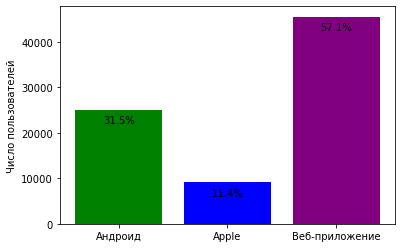

Red_android приложение имеет 25104 зарегестрированных пользователей
Red_apple приложение имеет 9106 зарегестрированных пользователей
Red_web приложение имеет 45538 зарегестрированных пользователей


In [9]:
counts = np.sum(df_red.drop(['HID','active_Red','is_msk'],axis=1),axis=0)
counts
plt.bar(np.arange(3), counts, color = ['green','blue','purple'])
plt.xticks(np.arange(3), ['Андроид', 'Apple', 'Веб-приложение'])
plt.ylabel('Число пользователей')
for i, count in enumerate(counts):
    percent = count / counts.sum() * 100
    plt.text(i, count - 3000, f'{round(percent,1)}%', ha='center')
plt.show()
for key,value in counts.items(): 
    print(key+' приложение имеет '+ str(value)+ ' зарегестрированных пользователей')

In [10]:
aap, aw=df_red[((df_red.Red_android!=0)&(df_red.Red_apple!=0))],df_red[((df_red.Red_android!=0)&(df_red.Red_web!=0))]
apw, aapw =df_red[((df_red.Red_apple!=0)&(df_red.Red_web!=0))],df_red[((df_red.Red_android!=0)&(df_red.Red_apple!=0)&(df_red.Red_web!=0))]
print(f'• {aap.shape[0]} человек пользуются одновременно Apple и Android приложением, то есть {round(aap.shape[0]/df_red.active_Red.sum(),2)*100}%')
print(f'• {aw.shape[0]} человек пользуются одновременно Android и Веб-приложением, то есть {round(aw.shape[0]/df_red.active_Red.sum(),2)*100}%')
print(f'• {apw.shape[0]} человек пользуются одновременно Apple и Веб-приложением, то есть {round(apw.shape[0]/df_red.active_Red.sum(),2)*100}%')
print(f'• {aapw.shape[0]} человек пользуются одновременно Всеми приложениями, то есть {round(aapw.shape[0]/df_red.active_Red.sum(),2)*100}%')
print()
print('Речь идет тоьлко о зарегестрированных клиентах. Связка Андроид и веб приложения используется у каждого 3 клиента')

• 2778 человек пользуются одновременно Apple и Android приложением, то есть 5.0%
• 20073 человек пользуются одновременно Android и Веб-приложением, то есть 36.0%
• 7050 человек пользуются одновременно Apple и Веб-приложением, то есть 13.0%
• 2314 человек пользуются одновременно Всеми приложениями, то есть 4.0%

Речь идет тоьлко о зарегестрированных клиентах. Связка Андроид и веб приложения используется у каждого 3 клиента


# Blue company

## Общее

In [11]:
print( '• Компания имеет '+ f'{df_blue.shape[0]} клиентов, из которых {np.sum(df_blue.is_msk)} (то есть {round(np.sum(df_blue.is_msk)/df_blue.has_Blue_id.sum(),2)*100}%) расположен в Москве')
print(f'• Доля на рынке: {np.round(df_blue.shape[0]/100000 ,3)*100}%')

• Компания имеет 12746 клиентов, из которых 2031 (то есть 16.0%) расположен в Москве
• Доля на рынке: 12.7%


In [12]:
bg, bblack,br = df[((df.has_Blue_id!=0)&(df.has_Green_id!=0))],df[((df.has_Blue_id!=0)&(df.has_Black_id!=0))],df[((df.active_Red!=0)&(df.has_Blue_id!=0))]
nobody, allbody= df[((df.active_Red==0)&(df.has_Green_id==0)&(df.has_Black_id==0)&(df.has_Blue_id==0))],df[((df.active_Red!=0)&(df.has_Green_id!=0)&(df.has_Black_id!=0)&(df.has_Blue_id!=0))]
print(f'• {bg.shape[0]} человек пользуются одновременно имеют аккаунт в Blue и Green компаниях, то есть {round(bg.shape[0]/df_blue.shape[0],3)*100}%')
print(f'• {bblack.shape[0]} человек пользуются одновременно имеют аккаунт в Blue и Black компаниях, то есть {round(bblack.shape[0]/df_blue.shape[0],2)*100}%')
print(f'• {br.shape[0]} человек пользуются одновременно имеют аккаунт в Red и Blue компаниях, то есть {round(br.shape[0]/df_blue.shape[0],3)*100}%')
print(f'• {allbody.shape[0]} человек имеют аккаунт во всех 4-ех компаниях, то есть {round(allbody.shape[0]/df.shape[0],5)*100}%')
print(f'• {nobody.shape[0]} человек не имеют аккаунт ни в каких из этих 4-ех компаний, то есть {round(nobody.shape[0]/df.shape[0],5)*100}%')
print()
print('Большинство пользователей Blue компании часто зарегестрированы и в Red компании ')

• 162 человек пользуются одновременно имеют аккаунт в Blue и Green компаниях, то есть 1.3%
• 274 человек пользуются одновременно имеют аккаунт в Blue и Black компаниях, то есть 2.0%
• 8258 человек пользуются одновременно имеют аккаунт в Red и Blue компаниях, то есть 64.8%
• 20 человек имеют аккаунт во всех 4-ех компаниях, то есть 0.02%
• 38354 человек не имеют аккаунт ни в каких из этих 4-ех компаний, то есть 38.359%

Большинство пользователей Blue компании часто зарегестрированы и в Red компании 


## Мобильное приложение

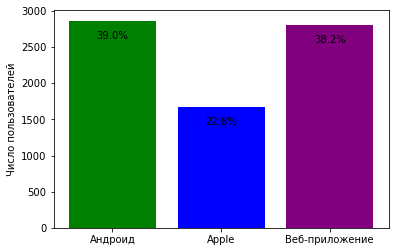

Blue_android приложение имеет 2867 зарегестрированных пользователей
Blue_apple приложение имеет 1674 зарегестрированных пользователей
Blue_web приложение имеет 2806 зарегестрированных пользователей


In [13]:
counts = np.sum(df_blue.drop(['HID','has_Blue_id','Blue_activity_count', 'Blue_gmv_total','is_msk'],axis=1),axis=0)
plt.bar(np.arange(3), counts, color = ['green','blue','purple'])
plt.xticks(np.arange(3), ['Андроид', 'Apple', 'Веб-приложение'])
plt.ylabel('Число пользователей')
for i, count in enumerate(counts):
    percent = count / counts.sum() * 100
    plt.text(i, count - 250, f'{round(percent,1)}%', ha='center')
plt.show()
for key,value in counts.items(): 
    print(key+' приложение имеет '+ str(value)+ ' зарегестрированных пользователей')

In [14]:
aap, aw=df_blue[((df_blue.Blue_android!=0)&(df_blue.Blue_apple!=0))],df_blue[((df_blue.Blue_android!=0)&(df_blue.Blue_web!=0))]
apw, aapw =df_blue[((df_blue.Blue_apple!=0)&(df_blue.Blue_web!=0))],df_blue[((df_blue.Blue_android!=0)&(df_blue.Blue_apple!=0)&(df_blue.Blue_web!=0))]
print(f'• {aap.shape[0]} человек пользуются одновременно Apple и Android приложением, то есть {round(aap.shape[0]/df_blue.has_Blue_id.sum(),3)*100}%')
print(f'• {aw.shape[0]} человек пользуются одновременно Android и Веб-приложением, то есть {round(aw.shape[0]/df_blue.has_Blue_id.sum(),3)*100}%')
print(f'• {apw.shape[0]} человек пользуются одновременно Apple и Веб-приложением, то есть {round(apw.shape[0]/df_blue.has_Blue_id.sum(),3)*100}%')
print(f'• {aapw.shape[0]} человек пользуются одновременно Всеми приложениями, то есть {round(aapw.shape[0]/df_blue.has_Blue_id.sum(),3)*100}%')
print()
print('Речь идет тоьлко о зарегестрированных клиентах - они предпочитают использовать один девайс')

• 212 человек пользуются одновременно Apple и Android приложением, то есть 1.7000000000000002%
• 577 человек пользуются одновременно Android и Веб-приложением, то есть 4.5%
• 294 человек пользуются одновременно Apple и Веб-приложением, то есть 2.3%
• 52 человек пользуются одновременно Всеми приложениями, то есть 0.4%

Речь идет тоьлко о зарегестрированных клиентах - они предпочитают использовать один девайс


## Анализ GMV активных пользователей в зависимости от города

In [15]:
def myfunc(df):
    a= stats.t.ppf((1+0.95)/2, df.shape[0]-1)
    return a

In [16]:
temp = df_blue[df_blue.Blue_activity_count>0].groupby('is_msk',
                                                      as_index=False).agg({'Blue_gmv_total':['sum','mean','std',myfunc],'Blue_activity_count':['sum','mean','std',myfunc],'HID':'count'})
temp.columns =['is_msk','Blue_gmv_total_sum','Blue_gmv_total_mean','Blue_gmv_total_std','Blue_t_value','Blue_activity_count_sum','Blue_activity_count_mean','Blue_activity_count_std','Blue_activity_t_value','HID_count']
temp['Avg_gmv_per_activity'] =temp.Blue_gmv_total_sum/temp.Blue_activity_count_sum
temp['Avg_gmv_per_user'] =temp.Blue_gmv_total_sum/temp.HID_count

<b>Доверительные интервалы (95%):</b>

In [17]:
import scipy.stats as stats
temp['GMV_нижняя граница доверительного интервала'] = temp.Blue_gmv_total_mean - temp.Blue_t_value *temp.Blue_gmv_total_std / np.sqrt(temp.HID_count)
temp['GMV_верхняя граница доверительного интервала'] = temp.Blue_gmv_total_mean + temp.Blue_t_value *temp.Blue_gmv_total_std / np.sqrt(temp.HID_count)
temp['Activity_нижняя граница доверительного интервала'] = temp.Blue_activity_count_mean	 - temp.Blue_activity_t_value *temp.Blue_activity_count_std / np.sqrt(temp.HID_count)
temp['Activity_верхняя граница доверительного интервала'] = temp.Blue_activity_count_mean	 + temp.Blue_activity_t_value *temp.Blue_activity_count_std / np.sqrt(temp.HID_count)

In [18]:
temp2 = temp[['is_msk','HID_count','Blue_gmv_total_sum','Avg_gmv_per_user','Avg_gmv_per_activity','GMV_нижняя граница доверительного интервала','GMV_верхняя граница доверительного интервала']]
temp2.columns =['Is_Moscow','Число пользователей', 'Общий объем товарообоота','GMV на пользователя', 'GMV на действие', 'GMV_нижняя граница доверительного интервала','GMV_верхняя граница доверительного интервала']
temp2

,Is_Moscow,Число пользователей,Общий объем товарообоота,GMV на пользователя,GMV на действие,GMV_нижняя граница доверительного интервала,GMV_верхняя граница доверительного интервала
0,0,2947,175546,59.567696,11.318976,34.664934,84.470458
1,1,606,58158,95.970297,16.470688,52.864478,139.076116


•  <b>Москве действительно меньше пользователей (в 4.86 раза), чем в остальных городах вместе взятых (логично)</b>  
•  <b>Тем не менее, сумма продаж (GMV, он же объем товарооборота) всего в 3 раза меньше</b>  
•  <b> Пользователь Москвы в среднем приносит 95 у.е. прибыли, тогда как в регионах это цифра всего лишь 59.у.е.</b>  
• <b>Пользователь Москвы в 95% cлучаев приносит 52 - 139 у.е прибыли, что в 1.5+ раза больше, чем в остальных городах (там 34-84 у.е. прибыли)</b>

In [19]:
temp3 = temp[['is_msk','HID_count','Blue_activity_count_sum','Avg_gmv_per_activity','Blue_activity_count_mean','Activity_нижняя граница доверительного интервала','Activity_верхняя граница доверительного интервала']]
temp3.columns =['Is_Moscow','Число пользователей', 'Общее число действий пользователя','GMV на действие', 'Среднее число действий','Activity_нижняя граница доверительного интервала','Activity_верхняя граница доверительного интервала']
temp3

,Is_Moscow,Число пользователей,Общее число действий пользователя,GMV на действие,Среднее число действий,Activity_нижняя граница доверительного интервала,Activity_верхняя граница доверительного интервала
0,0,2947,15509,11.318976,5.262640,4.956531,5.568749
1,1,606,3531,16.470688,5.826733,4.811169,6.842296


<b>• Пользователи Москвы в среднем совершают 5.8 действий, а в регионах всего лишь 5.2  
• Это действие в среднем ценнее в 1.45 раза  
• Для Москвичей норма (в 95% случаев) делать 4.8-6.85 действий в приложении, а для живуших в регионах - 4.95 - 5.56 действий</b>     

## Анализ GMV активных пользователей в зависимости от использования/игнорирования устройства

In [20]:
df_blue['has_profile'] = ((df_blue.Blue_android!=0)|(df_blue.Blue_apple!=0)|(df_blue.Blue_web!=0))
temp = df_blue[df_blue.Blue_activity_count>0].groupby('has_profile',
                                                      as_index=False).agg({'Blue_gmv_total':['sum','mean','std',myfunc],'Blue_activity_count':['sum','mean','std',myfunc],'HID':'count'})
temp.columns =['has_profile','Blue_gmv_total_sum','Blue_gmv_total_mean','Blue_gmv_total_std','Blue_t_value','Blue_activity_count_sum','Blue_activity_count_mean','Blue_activity_count_std','Blue_activity_t_value','HID_count']
temp['Avg_gmv_per_activity'] =temp.Blue_gmv_total_sum/temp.Blue_activity_count_sum
temp['Avg_gmv_per_user'] =temp.Blue_gmv_total_sum/temp.HID_count

<b>Доверительные интервалы (95%):</b>

In [21]:
import scipy.stats as stats
temp['GMV_нижняя граница доверительного интервала'] = temp.Blue_gmv_total_mean - temp.Blue_t_value *temp.Blue_gmv_total_std / np.sqrt(temp.HID_count)
temp['GMV_верхняя граница доверительного интервала'] = temp.Blue_gmv_total_mean + temp.Blue_t_value *temp.Blue_gmv_total_std / np.sqrt(temp.HID_count)
temp['Activity_нижняя граница доверительного интервала'] = temp.Blue_activity_count_mean	 - temp.Blue_activity_t_value *temp.Blue_activity_count_std / np.sqrt(temp.HID_count)
temp['Activity_верхняя граница доверительного интервала'] = temp.Blue_activity_count_mean	 + temp.Blue_activity_t_value *temp.Blue_activity_count_std / np.sqrt(temp.HID_count)

In [22]:
temp2 = temp[['has_profile','HID_count','Blue_gmv_total_sum','Avg_gmv_per_user','Avg_gmv_per_activity','GMV_нижняя граница доверительного интервала','GMV_верхняя граница доверительного интервала']]
temp2.columns =['Есть профиль','Число пользователей', 'Общий объем товарообоота','GMV на пользователя', 'GMV на действие', 'GMV_нижняя граница доверительного интервала','GMV_верхняя граница доверительного интервала']
temp2

,Есть профиль,Число пользователей,Общий объем товарообоота,GMV на пользователя,GMV на действие,GMV_нижняя граница доверительного интервала,GMV_верхняя граница доверительного интервала
0,False,1381,110710,80.166546,14.389134,29.062638,131.270454
1,True,2172,122994,56.627072,10.840296,41.411505,71.842639


•  <b>Людей без профиля действительно меньше пользователей (в 1.57 раза), чем людей с профилем</b>   
•  <b>Тем не менее, сумма продаж (GMV, он же объем товарооборота) у 2-ух групп почти равна</b>  
•  <b>В среднем пользователь без профиля приносит 80 у.е., а прользователь с профилем - 56 у.е.  
•  <b> Люди без профиля в 95% случаев действуют намного более разнообразно - размах доверительного интервала - 102 у.е против 30 у.е. у людей с профилем  
•  <b>Пользователь с профилем в 95% cлучаев приносит 41 - 71 у.е прибыли, а без профиля там 29-131 у.е. прибыли</b>  

In [23]:
temp3 = temp[['has_profile','HID_count','Blue_activity_count_sum','Avg_gmv_per_activity','Blue_activity_count_mean','Activity_нижняя граница доверительного интервала','Activity_верхняя граница доверительного интервала']]
temp3.columns =['Есть профиль','Число пользователей', 'Общее число действий пользователя','GMV на действие', 'Среднее число действий','Activity_нижняя граница доверительного интервала','Activity_верхняя граница доверительного интервала']
temp3

,Есть профиль,Число пользователей,Общее число действий пользователя,GMV на действие,Среднее число действий,Activity_нижняя граница доверительного интервала,Activity_верхняя граница доверительного интервала
0,False,1381,7694,14.389134,5.571325,4.988141,6.154509
1,True,2172,11346,10.840296,5.223757,4.884329,5.563185


<b>• Пользовататели с профилем делают немного (на 0.5) меньше действий, чем пользователи с профилем</b>

## Самые-самые: активные и платящие (поиск аномалий)

<AxesSubplot:xlabel='Blue_gmv_total', ylabel='Blue_activity_count'>

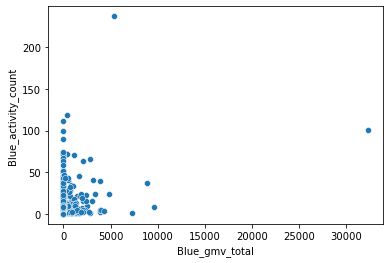

In [24]:
sns.scatterplot(data=df_blue, x='Blue_gmv_total',y='Blue_activity_count')

На графике явно видно выбросы, и часть точек имеет отклонения. Стоит их рассмотреть

In [25]:
top_paying_users = df_blue[df_blue.Blue_gmv_total>139].sort_values('Blue_gmv_total',ascending=False)
top_paying_users.head(5)

,HID,has_Blue_id,Blue_activity_count,Blue_gmv_total,Blue_android,Blue_apple,Blue_web,is_msk,has_profile
59566,15be8031125370c0cbc5d25d1bdf6bde78,1,101,32302,0,0,0,0,False
14170,051f1368d52585f73d33355ef563c2581b,1,8,9612,0,0,0,0,False
94262,3325bff1103ce6fcc311c9d9b25db1d3b7,1,37,8902,0,1,0,0,True
93347,31f8d36bb3f7675255d39bdd63bbbd388,1,1,7286,1,0,1,1,True
80797,1d75bf57725ce325b25b87e1255bebbfb713,1,237,5354,0,0,0,1,False


In [26]:
top_active_users = df_blue[df_blue.Blue_activity_count>100].sort_values('Blue_activity_count',ascending=False)
top_active_users

,HID,has_Blue_id,Blue_activity_count,Blue_gmv_total,Blue_android,Blue_apple,Blue_web,is_msk,has_profile
80797,1d75bf57725ce325b25b87e1255bebbfb713,1,237,5354,0,0,0,1,False
11206,0250fb7d38789c9b1bb9325b82553250b5cf,1,119,378,0,0,0,0,False
61035,16258725b25f25b1e25d6b5300668bb6d256de,1,111,0,0,1,0,0,True
59566,15be8031125370c0cbc5d25d1bdf6bde78,1,101,32302,0,0,0,0,False


<b>• У нас есть особенный человек, который совершил 101 действие и обошел любого конкурента в 3.5 раза по прибыли - он принес 32202 у.е  
• Есть человек, у которого самый большой чек за одну покупку - он принес 7286 у.е прибыли за одно действие  
• И есть очень активный пользователь, который обошел по количеству действия всех остальных в 2+ раза  </b>

# Аналогичный разведовательный анализ можно провести по 2 оставшимся компаниям, но зачем в файле-демонстрации своей работы 4 повторяющихся модуля? Поэтому делать не стал, хотя мог

### Но можно было бы также посчитать чуть больше интересных метрик, тк у двух оставшихся компаний есть интересная колонка "Число заказов" (раньше не встречалась)

### Например можно было проанализировать: 
### 1) Cреднюю стоимость заказа в разрезе по приложениям или городу, наличию аккаунта и тд, 
### 2) Cколько действий обычно совершается для выполнения заказа
### 3) Какой процент пользователей "просто смотрели", но не заказывали и т.д. 
### Эти метрики я считал в своих пет-проектах

# Предсказание - есть ли у человека Веб-приложение?

In [27]:
df['has_app'] = False
df['has_android']= False
df['has_apple']= False
#df.loc[((df.Blue_android!=0)|(df.Blue_apple!=0)|(df.Blue_web!=0)|(df.Red_android!=0)|(df.Red_apple!=0)|(df.Red_web!=0)|(df.Green_android!=0)|(df.Green_apple!=0)|(df.Green_web!=0)|(df.Black_android!=0)|(df.Black_apple!=0)|(df.Black_web!=0)), 'has_app'] = True
df.loc[((df.Green_web!=0)|(df.Black_web!=0)|(df.Red_web!=0)|(df.Blue_web!=0)), 'has_app'] = True
df.loc[((df.Green_android!=0)|(df.Black_android!=0)|(df.Red_android!=0)|(df.Blue_android!=0)), 'has_android'] = True
df.loc[((df.Green_apple!=0)|(df.Black_apple!=0)|(df.Red_apple!=0)|(df.Blue_apple!=0)), 'has_apple'] = True

In [28]:
df.groupby('has_app').HID.count()

has_app
False    32405
True     67581
Name: HID, dtype: int64

<b>У нас наблюдается дисбаланс классов 68% против 32, что не является супер-критичным, поэтому использование оверсемплинга, или андерсемплинга может испортить данные - лучше работать с тем, что есть</b>

Baseline = 67.58%

<b>В качестве метрики я выбрал F1-score, который использует и Precision, и Recall, и является оптимальным выбором в задачах, которые не имеют каких-то особых условий, кроме как "предскажите максимально точно"</b>

In [29]:
from sklearn.model_selection import train_test_split
#Разобьем на train и test
data = df.drop(['HID','Red_web', 'Green_web', 'Black_web', 'Blue_web'],axis=1)
train, test = train_test_split(data, test_size=0.3, random_state=42)
X_train,y_train = train.drop('has_app',axis=1), train.has_app
X_test,y_test = test.drop('has_app',axis=1), test.has_app

In [30]:
#Отберем лучшую модель по параметрам выше и с помощью кросс валидации на 5 частей
parametrs={'criterion': ['entropy'], 'max_depth': range(1,15),'min_samples_leaf':range(1,100,10)}
clf=tree.DecisionTreeClassifier()
grid_search_cv_clf=GridSearchCV(clf,parametrs, cv=5)
grid_search_cv_clf.fit(X_train,y_train)
grid_search_cv_clf.best_params_

{'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 11}

In [31]:
best_clf=tree.DecisionTreeClassifier(criterion='entropy',max_depth=8, min_samples_leaf=11,random_state=42)

In [32]:
best_clf.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=11,
                       random_state=42)

In [33]:
best_clf.score(X_test,y_test)

0.7004933991198826

In [34]:
y_pred=best_clf.predict(X_test)

In [35]:
f_one_score = metrics.f1_score(y_test,y_pred)
precision = metrics.precision_score(y_test, y_pred)

In [36]:
f_one_score

0.7817934518604877

[Text(169.26243455497382, 205.35999999999999, 'X[0] <= 0.5\nentropy = 0.91\nsamples = 69990\nvalue = [22738, 47252]'),
 Text(83.42611256544502, 181.2, 'X[19] <= 0.5\nentropy = 1.0\nsamples = 30902\nvalue = [15526, 15376]'),
 Text(49.40929319371728, 157.04, 'X[14] <= 0.5\nentropy = 0.998\nsamples = 25179\nvalue = [13238, 11941]'),
 Text(29.579842931937172, 132.88, 'X[4] <= 0.5\nentropy = 0.999\nsamples = 24081\nvalue = [12555, 11526]'),
 Text(20.596335078534032, 108.72, 'X[3] <= 0.5\nentropy = 0.999\nsamples = 23358\nvalue = [12091, 11267]'),
 Text(13.146596858638745, 84.56, 'X[18] <= 0.5\nentropy = 0.998\nsamples = 21669\nvalue = [11359, 10310]'),
 Text(7.01151832460733, 60.400000000000006, 'X[7] <= 0.5\nentropy = 0.997\nsamples = 19456\nvalue = [10324, 9132]'),
 Text(3.505759162303665, 36.24000000000001, 'X[8] <= 1791.0\nentropy = 0.998\nsamples = 19353\nvalue = [10232, 9121]'),
 Text(1.7528795811518325, 12.079999999999984, 'entropy = 0.998\nsamples = 19253\nvalue = [10156, 9097]'),
 

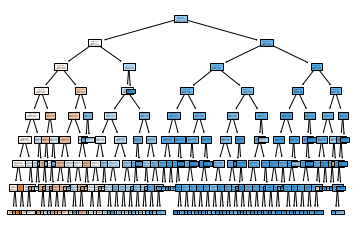

In [37]:
tree.plot_tree(best_clf,filled=True)

#### Самые верхние параметры разделения в дереве:  
1) Наличие аккаунта Red  
2) Проживание в Мск  
2) Наличие аккаунта Green  
3) Наличие аккаунта Blue  
3) Прибыль от клиента меньше 1325 у.е.  

## Но это плохое предсказание - оно хуже Baseline

In [38]:
y_true = np.array([True for x in y_pred])

In [39]:
metrics.f1_score(y_test,y_true)

0.8079085941381023

<b>Решение получилось хуже чем Baseline  
В связи с чем это могло случиться?</b>

<AxesSubplot:>

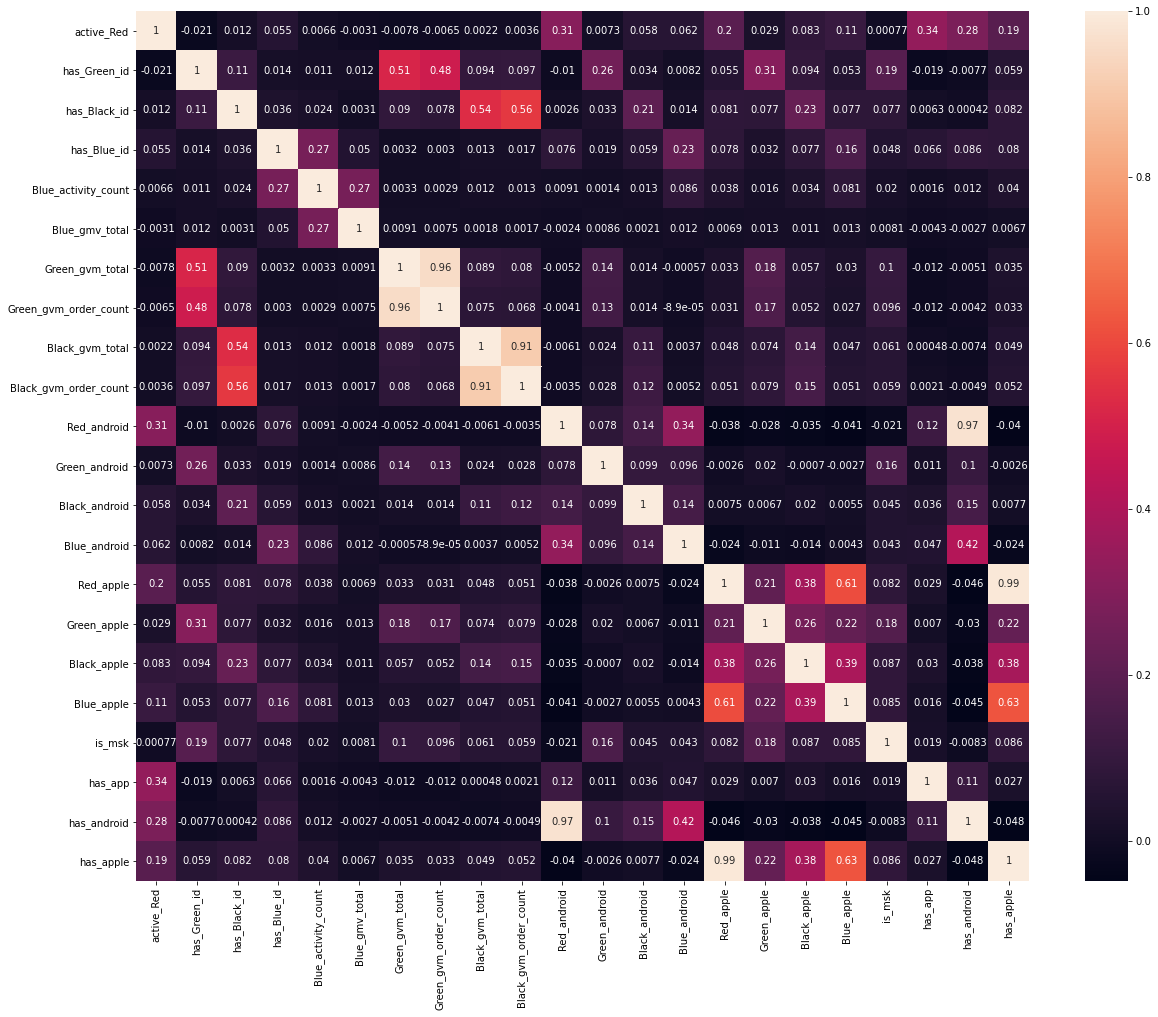

In [40]:
plt.figure(figsize=(20,16))
sns.heatmap(data.corr(),annot=True)

## Дело в том, что has_app Слабо коррелирует с любыми другими колонками, поэтому найти какие-то взаимосвязи наличия веб-приложения по данным переменным - тяжелая задача, которая требует большего времени для рассмотрения